# Image Recognition with Tensorflow 1
Adapted from [Tensorflow Image Classification Walkthrough](https://www.tensorflow.org/tutorials/images/classification).

This is the first part of the Image Recognition workshop series, where we will be making a first pass at a model to differentiate flower types by images. 

## Machine learning and deep learning


Machine learning (ML) and deep learning (DL) are tools to made predictions. We train models up on data; they become good at making predictions on those data, and then we feed them new information and see how they do on the new information.


<img src="https://assets-global.website-files.com/5fb24a974499e90dae242d98/60f6feb4be651f666b46194a_AI%20vs%20Machine%20Learning%20vs%20Deep%20Learning.jpg"  width="50%">



We use ML and DL to model complex systems with complicated relationships. If your data is relatively simple, machine learning and deep learning are likely not the best choice; will take longer and may do worse than more simple models.


## Setup

First, we import `tensorflow` and other libraries that we will be using for the analysis. These libraries contain various tools not found in base Python that we will need.

<details>

<summary>More info</summary>

`matplotlib` is used for creating figures. Numpy is used for mathematical operations. `PIL` is used to visualize image files (jpg, png, etc.).

We will be using several modules within tensorflow. keras is a neural network framework built into tensorflow, and we will relying on it for the models we make. 

`tensorflow` makes use of tensors: multi-dimension arrays of data. If you are familiar with numpy arrays, tensors are similar, but optimized for deep learning.
</details>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2023-07-11 16:20:59.134183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Our first step is to download the data set and decompress it. The data contains 5 subdirectories for our flower types: daisy, dandelion, roses, sunflowers, tulips.

<details>
<summary>More information</summary>

```python
import pathlib
```
[`pathlib`](https://realpython.com/python-pathlib/) allows us to use and interact with file paths.

```python
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
```

The data we are using is directly from tensorflow. It is located online in a compressed file format. We create a string variable `dataset_url` that points at the URL where the file is stored. This file can be uncompressed into a folder containing our image files. 

```python
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
```
Here, we are using a function we imported. Inside of `tf`, there is a submodule called `keras`, which itself contains a submodule called `utils`. We are using a function called [`get_file()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) from [`utils`](https://www.tensorflow.org/api_docs/python/tf/keras/utils). This function will download the compressed data at our URL (what we feed into `origin`). `flower_photos` is name we'll give to the folder when we uncompress. `untar=True` makes sure that we uncompress the file right when we download. 

We save the path where we saved the folder as `data_dir`.

```python
data_dir = pathlib.Path(data_dir)
```

We finally convert the path to folder to a `pathlib.Path` object, which will allow us easy access to the files in those folders.
</details>

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

Let's display our sample size to see how many images we're working with.

<details>

<summary>
More info
</summary>

Because `data_dir` is a pathlib.Path object, we use its `.glob()` method (stands for global) to find files with that directory. Inside of the folder we downloaded, there are 5 folders, one for each type of flower. `.glob('*/*.jpg')` means "from all subfolders (\*/), grab all files that end in '.jpg'). The "\*" is a wildcard that match any number of characters. 

`.glob()` gives us all the file names in a `generator`. We convert it to a `list` to make it easier to handle, and then we take the `len` to see how many files there are in all of our folders. 

</details>

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


3670


We use the PIL library we imported to open and view images.

<details>

<summary>More info</summary>

Here, instead of looking at all the files with `(*/*.jpg)`, we pick only the files with roses in them with `roses/*.jpg`.

[`PIL.Image.open()`](https://www.geeksforgeeks.org/python-pil-image-open-method/) displays an image file, given a file path. Here, we take the path to first rose file, and cast the path as a string to be usable by the PIL function. 

</details>

641


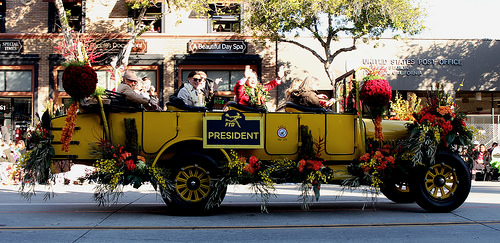

In [4]:
roses = list(data_dir.glob('roses/*.jpg'))
print(len(roses))
PIL.Image.open(str(roses[0]))

Here, we take a look at another rose.

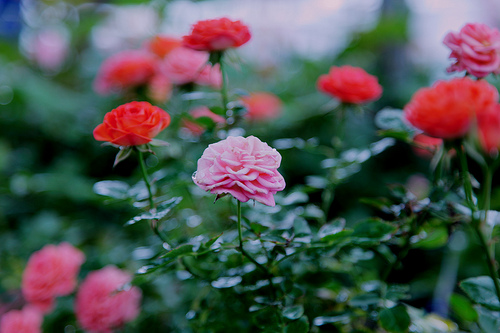

In [5]:
PIL.Image.open(str(roses[1]))


We can do the same for the tulips images. 

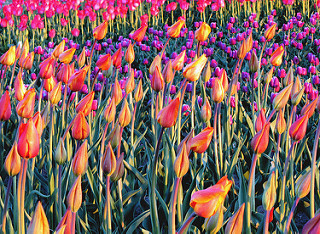

In [6]:
tulips = list(data_dir.glob('tulips/*.jpg'))
PIL.Image.open(str(tulips[0]))

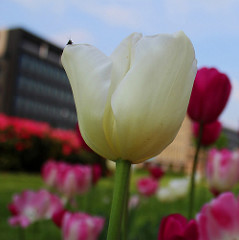

In [7]:
PIL.Image.open(str(tulips[1]))


Let's breakdown our data by type of flower to see if we have imbalanced data -> more of some types of flowers than others.

If we have an overwhelming amount of one type, our model will primarily be trained on that type, which will make differentiating between types difficult.

In [8]:
daisy = list(data_dir.glob('daisy/*.jpg'))
sunflowers = list(data_dir.glob('sunflowers/*.jpg'))
dandelion = list(data_dir.glob('dandelion/*.jpg'))

print('roses:',len(roses))
print('tulips:',len(tulips))
print('daisy',len(daisy))
print('sunflower',len(sunflowers))
print('dandelion',len(dandelion))

roses: 641
tulips: 799
daisy 633
sunflower 699
dandelion 898


## Load data as a keras dataset

While our data is accessible to Python, we need to do some extra steps to make it usable in tensorflow. For instance, we'll need to make sure all images have the same height and width. 

We then will split our data into two subsets: **training** and **validation**. The training subset is used to construct the model, and the validation subset is used to see how well our model performs.

<img src="https://b1739487.smushcdn.com/1739487/wp-content/uploads/2021/04/train-and-test-1-min-1.png?lossy=0&strip=1&webp=1" alt="AI" width=400px>

<br>
<br>

<details>

<summary>More info</summary>

For our purposes, we are going to use the function [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) from [`tf.keras.utils`](https://www.tensorflow.org/api_docs/python/tf/keras/utils). We first call this function with `subset="training"` to grab the training set.

We make the training-validation split 80-20 to make sure we use most of the data for training, but that we still have enough left over for validation. We specify the split with `validation-split`.

We also are going to specify a batch size, which helps with loading images into memory. For us, 32 images will be loaded in at once.

We are going to reformat our images to be square: 180x180. This pipeline requires that all images be identical in size and shape. This does mean we will squish images that were not square already, and we lose some pixel density on larger images. We specify this in the argument `image_size` as a tuple.

</details>

In [9]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2023-07-11 16:21:05.480789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We can run the same command again to get the validation set. Beyond specifying `subset="validation"`, make sure to keep the parameters `validation_split` and `seed`, the same as for the training set to ensure the split is complementary to the training set. `image_size` and `batch_size` should also be kept the same for consistency.

In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Let's save the names of our flowers (our class names), and print them out using the `.class-name` attribute.

In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Now that we've loaded our data into tensorflow, let's visualize it again after re-sizing images.

<details>
<summary>More info</summary>

While we can visualize our images in a similar way to before, here we use `matplotlib` to organize our images into a 3x3 grid.

First, we define a 10x10 figure.

```python
plt.figure(figsize=(10, 10))
```
We can grab a single batch from our data with `train_ds.take(1)`. Converting to a list lets us pull out individual images and labels. 

```python
images, labels = list(train_ds.take(1))[0]
```

We iterate over a range of 9 for our 9 total images. 

`ax = plt.subplot(3, 3, i + 1)` makes sure we are plotting on the right set of axes for our image.

```python
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
```

`plt.imshow()` displays image data. We take our images TALK ABOUT THE CONVERSION.


```python
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(class_names[labels[i]])
  plt.axis("off")
```

</details>

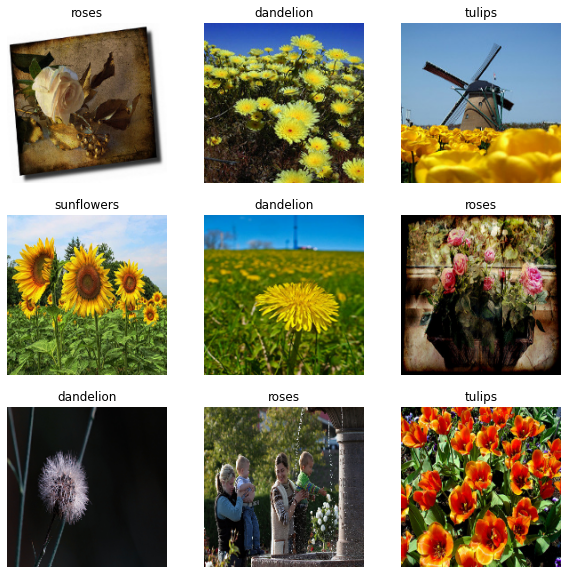

In [12]:
plt.figure(figsize=(10, 10))
images, labels = list(train_ds.take(1))[0]

for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(class_names[labels[i]])
  plt.axis("off")


### Image batching

Each batch has 32 images, 180x180 pixels, with RGB data.

Each image has an accompanying label, as well. 

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


We're also going to configure the dataset for performance.

`dataset.cache()` keeps images in memory so that we don't need to load them each epoch.
`dataset.prefetch()` prepares images ahead of time while current image is being worked on. Uses additional memory. 

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Image data and normalization 

You can think of image data as a series of numerical values that are interpreted to create something visual. 

Here is a simplification, where we have a 2D array of zeros and ones. Zero is interpreted as black (no color), and one is interpreted as white (max color).

<img src="https://cs50.harvard.edu/college/2022/spring/psets/4/filter/more/bitmap.png" alt="Image data" width=400px>

<br>

In reality, images don't just contain black and white pixels: they have pixels that values for red, green, and blue (RGB) at different intensities.

Each pixel has 3 values for RGB intensity, combining to look like a single color to our eyes.

<img src="https://learn.g2crowd.com/hubfs/rgb%20colors.png" alt="RGB data" width=400px>

<br>


The intensity values go from 0 through 255, which we can see in our own data by looking at the maximum and minimum values of an image.

In [15]:
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 255.0


Neural networks like input values to be small, so we transform them to be between 0.0 and 1.0. 

<img src="https://e2eml.school/images/image_processing/three_d_array.png" alt="Image channels" width=400px>

<br>

Here, we test this out by create a normalization layer and then check to make sure the normalization works. 

In [16]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Building a model

Now that we gone through our preprocessing workflow, we are going to construct a basic Keras model, which contains several **layers**. Layers take information, process them in some way, and then pass the output on to different layers. 

We are going to build [a sequential model](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential), which puts layers in a defined order, and feeds data through the layers in that order. Each layer will have a single tensor input and a single tensor output.

<img src="https://www.tutorialspoint.com/tensorflow/images/multi_layer_perceptron.jpg" alt="model diagram" width=600px>

<br>


We are starting our basic model with the following layers:

- [Rescaling layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling): works like above example. Our data contains 3 dimensions: x position, y position, and RGB channel
- [Flatten layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten): removes dimensional component into a single dimension; only reformats our data
- [Dense layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): a layer that is fully connected to the previous layer. 
  - Our Dense layer has 32 neurons or nodes. Every node is receives information about all pixels
  - Use `relu` activation. Activation functions determines how strongly each neuron "fires" -> to what degree each node gets used to make predictions
- ends with another Dense layer with 5 nodes, one for each class. It will contain the odds of the images being each flower type. 

In [17]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

We then compile our model with `model.compile()`, adding in a few more important options. 

Loss is how the training process determines how well it is doing. We want loss to be as close to zero as possible. There are many possible loss functions; here we use one called sparse categorical cross entropy. 

Our optimizer tries to decide how to make changes to our model to decrease loss. 

In the example below, the optimizer is trying to find the lowest point on the parabola. It tries to take larger steps when it's far away from the minimum, and smaller steps when it's near.

If it takes steps that are too large, however, the model may have a hard time finding the minimum loss due to overshooting. 

<img src="https://1.cms.s81c.com/sites/default/files/2020-10-27/Learning%20Rate.jpg" alt="gradient descent" width=800px>

<br>

Reality is more complicated than this simple case. Here we show a more complicated gradient. It contains many places for the minimization process to get stuck (local minima). Therefore, making sure our step size is large enough to get out of local minima is also important. 

<img src="../data/gradient-decent-3d.png" alt="complex gradient" width=700px>

<br>

We also will keep track of the accuracy of our model. This is the proportion of images that the model correctly classifies. The model does not use this information; it is purely for us, the users.

<details>

<summary>More info</summary>

We use a type of loss called sparse categorical cross entropy. However, there are [many different kinds of loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses) we can use.

There are also [different metrics we can track](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) besides accuracy, as well. If we add them to the list, we can track multiple metrics at the same time. 

We use an optimizer called "Adam" commonly used in neural networks. [Other optimers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) can be usedm as well. 

</details>

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

We can print model summary, which shows our layers and how many parameters we have for each layer. 

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 flatten (Flatten)           (None, 97200)             0         
                                                                 
 dense (Dense)               (None, 32)                3110432   
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 3,110,597
Trainable params: 3,110,597
Non-trainable params: 0
_________________________________________________________________


We are going to run the model for 10 **epochs**. An **epoch** is one iteration through the model pipeline where the model can adjust itself throughout. This means that we will pass our entire data set through our model 10 times. After the first epoch, future epochs will build upon the model created in prior epochs and refine it to minimize the **loss**.

Here, we use `model.fit()` to actually fit the model that we have defined. We will call the output of the model fitting `history`, as it will store a record of the fitting process over time. 

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 1s 7ms/step - loss: 3.8806 - accuracy: 0.2016 - val_loss: 1.6087 - val_accuracy: 0.2398
Epoch 2/10
92/92 [==============================] - 0s 4ms/step - loss: 1.6073 - accuracy: 0.2459 - val_loss: 1.6065 - val_accuracy: 0.2398
Epoch 3/10
92/92 [==============================] - 0s 4ms/step - loss: 1.6051 - accuracy: 0.2459 - val_loss: 1.6048 - val_accuracy: 0.2398
Epoch 4/10
92/92 [==============================] - 0s 4ms/step - loss: 1.6034 - accuracy: 0.2459 - val_loss: 1.6036 - val_accuracy: 0.2398
Epoch 5/10
92/92 [==============================] - 0s 4ms/step - loss: 1.6022 - accuracy: 0.2459 - val_loss: 1.6028 - val_accuracy: 0.2398
Epoch 6/10
92/92 [==============================] - 0s 4ms/step - loss: 1.6014 - accuracy: 0.2459 - val_loss: 1.6023 - val_accuracy: 0.2398
Epoch 7/10
92/92 [==============================] - 0s 4ms/step - loss: 1.6009 - accuracy: 0.2459 - val_loss: 1.6021 - val_accuracy: 0.2398
Epoch 8/10
92/92 [==

We can visualize the results of our model in matplotlib, looking both at the training and validation sets. For each we look at accuracy, as well as loss. 

Here is an example of how we want our plot to look:

![good training plot](../data/good_training.png)

Here, the validation accuracy slowly increases to be around 75%. It is a little smaller than the training accuracy, because we are always more accurate on the data that the model has already seen than on new data. 

When we look at training and validation loss, the absolute values are less important. However, we want to see loss decrease as we train the model. Smaller loss is better. We will see validation loss be larger than training loss, similar to how validation accuracy is always smaller than training accuracy. 

<details>

<summary>More info</summary>

We saved the record of the fitting process and the resulting model in a variable called `history`. This variable has an attribute `.history`, which is a dictionary containing information about our fitting.

For instance, `history.history['accuracy']` contains the training accuracy across our epochs, while `history.history['val_accuracy']` contains the validation accuracy. Likewise, `history.history['loss']` is the training loss, and `history.history['val_loss']` is the validation loss. 

We then plot each one in their own subplots. 

</details>

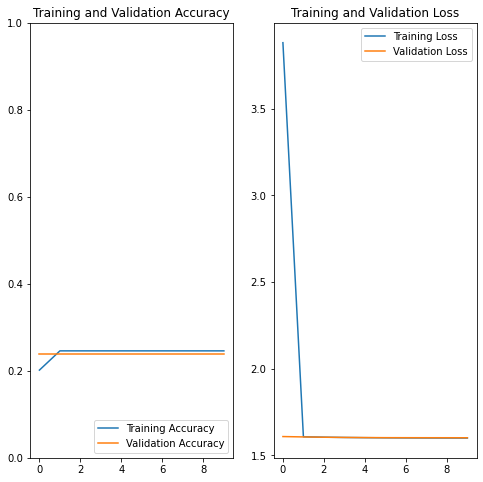

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Our model isn't performing particularly well. Next time, we will go over ways to fix it to be more accurate. 

## Homework: TensorFlow Playground

Using [TensorFlow Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.80210&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false), create the best model possible.